In [1]:
import pandas as pd
import datetime
from collections import Counter
import os
import shutil

In [2]:
final_financial_data_directory = 'final_financial_data'
final_financial_data_in_date_range_directory = 'final_financial_data_in_date_range'
final_financial_data_processed_17_variables_directory = 'final_financial_data_processed_17_variables'
final_financial_data_processed_100_variables_directory = 'final_financial_data_processed_100_variables'
final_financial_data_processed_17_variables_5years_directory = 'final_financial_data_processed_17_variables_5years'
final_financial_data_processed_17_variables_5years_version2_directory = 'final_financial_data_processed_17_variables_5years_version2'

In [3]:
eligible_companies = pd.read_csv('companies_eligible_to_financial_dataset_2024-04-19_14-47-55.csv')
eligible_companies.head()

,Unnamed: 0,cik,company,label,ticker,gurufocus-company-name,gurufocus-stockid,filing_date,cik-equal-gurufocus-cik,first_match
0,0,1800,ABBOTT LABORATORIES,False,ABT,Abbott Laboratories,US066X,2021-02-19,True,NaN
1,1,2488,ADVANCED MICRO DEVICES INC,False,AMD,Advanced Micro Devices Inc,US022E,2021-01-29,True,NaN
2,2,2491,"BALLY TECHNOLOGIES, INC.",False,BYI,Bally Technologies Inc (Delisted),US06R5,2014-08-29,True,NaN
3,3,2601,AEROFLEX INC,False,ARXX,Aeroflex Inc (Delisted),US026H,2006-09-13,True,NaN
4,4,2969,AIR PRODUCTS & CHEMICALS INC /DE/,False,APD,Air Products & Chemicals Inc,US06DU,2021-11-18,True,NaN


In [4]:
eligible_companies['label'].value_counts()

label
False    5291
True      126
Name: count, dtype: int64

In [5]:
final_eligible_companies = eligible_companies.copy()

In [6]:
def drop_columns_after_ttm_or_preliminary(df):
    try:
        try:
            ttm_index = df.columns.get_loc('TTM')
            df = df.iloc[:, :ttm_index]
            return df
        except:
            pass
            
        try:
            ttm_preliminary_string = 'TTM  Preliminary'
            ttm_index = df.columns.get_loc(ttm_preliminary_string)
            df = df.iloc[:, :ttm_index]
            return df
        except:
            print(f'No \'TTM  Preliminary\' column in {filename}')
            
        try:
            preliminary_string = 'Preliminary'
            preliminary_index = None
            for i, s in enumerate(df.columns):
                if preliminary_string in s:
                    preliminary_index = i
                    break
                    
            df = df.iloc[:, :preliminary_index + 1]
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            updated_col_name = f'{split_date[0]} {split_date[1]}'
            
            df.rename(columns={last_column_name: updated_col_name}, inplace=True)
            
            print(f'No TTM but found Preliminary in {filename}')
        except:
            print(f'No Preliminary column in {filename}')
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')
    
    return df

def clean_date_index(df):
    for index in df.index:
        split_date = index.split(' ')
        month, year = split_date[0], int(split_date[1])
        
        if 0 <= year <= 9:
            year = f'200{year}'
        elif 10 <= year <= 24:
            year = f'20{year}'
        elif year > 24:
            year = f'19{year}'
            
        df.rename(index={index: f'{month} {year}'}, inplace=True)
    return df

In [9]:
def set_date_difference(final_eligible_companies):

    for index, row in final_eligible_companies.iterrows():
        try:
            cik = row['cik']
            gurufocus_stockid = row['gurufocus-stockid']
            ticker = row['ticker']
            filing_date = row['filing_date']
                
            filepath = f'{final_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
                
            df = pd.read_csv(filepath)
            
            df = drop_columns_after_ttm_or_preliminary(df)
            
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            month, year = split_date[0], int(split_date[1])
            
            if 0 <= year <= 9:
                year = f'200{year}'
            elif 10 <= year <= 24:
                year = f'20{year}'
            elif year > 24:
                year = f'19{year}'
                
            gurufocus_last_data_date = datetime.datetime.strptime(f'{month} {year}', '%b %Y')
            
            filing_date = filing_date[:7]
            filing_date = datetime.datetime.strptime(f'{filing_date}', '%Y-%m')
    
            difference_in_months = int((gurufocus_last_data_date - filing_date).days / 30)
            
            final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'difference_in_months'] = difference_in_months
        
        except Exception as ex:
            print(f'Ex: {ex}, filepath: {filepath}')
        
    return final_eligible_companies

In [10]:
final_eligible_companies = set_date_difference(final_eligible_companies)

Ex: invalid literal for int() with base 10: 'Period', filepath: final_financial_data/1766526-US26IG_TECTP.PFD.csv


In [11]:
counts_df = final_eligible_companies['difference_in_months'].value_counts()
# set column names
counts_df = counts_df.reset_index()
counts_df.columns = ['difference_in_months', 'count']
counts_df.head()

,difference_in_months,count
0,-3.0,1398
1,34.0,1190
2,-2.0,825
3,33.0,676
4,22.0,325


In [12]:
def get_companies_within_date_range(final_eligible_companies):
    mask = (final_eligible_companies['difference_in_months'] > -12) & (final_eligible_companies['difference_in_months'] < 36)
    eligible_companies_in_eligible_range = final_eligible_companies[mask]
    eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
    return eligible_companies_in_eligible_range

def drop_unused_columns(final_eligible_companies):
    final_eligible_companies.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)
    return final_eligible_companies

#### Processing I

In [13]:
final_eligible_companies = get_companies_within_date_range(final_eligible_companies)
final_eligible_companies = drop_unused_columns(final_eligible_companies)

print(len(final_eligible_companies))
final_eligible_companies['label'].value_counts(normalize=True)

5078


C:\Users\grzeg\AppData\Local\Temp\ipykernel_38644\3847550151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
C:\Users\grzeg\AppData\Local\Temp\ipykernel_38644\3847550151.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_eligible_companies.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)


label
False    0.976959
True     0.023041
Name: proportion, dtype: float64

In [45]:
# final_eligible_companies.to_csv('eligible_companies_in_eligible_range.csv', index=False)

In [46]:
for index, row in final_eligible_companies.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    filing_date = row['filing_date']
    
    filepath = f'{final_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
        
    shutil.copy(filepath, f'./{final_financial_data_in_date_range_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv')

#### Processing II - creating set of files with 17 variables

In [14]:
final_eligible_companies = pd.read_csv('eligible_companies_in_eligible_range.csv')
len(final_eligible_companies)

5078

In [15]:
with open('chosen_variables.txt', 'r') as file:
    chosen_variables = file.read().splitlines()
    
with open('most_common_variables.txt', 'r') as file:
    most_common_variables = file.read().splitlines()

In [16]:
def delete_duplicated_rows(df):
    df.drop(df.index[df.iloc[:, 0].duplicated(keep=False)], inplace=True)
    return df

def has_dataframe_enough_variables(df, variables, threshold):
    csv_variable = df.iloc[:, 0].tolist()
    lacking_variables = []
    for variable in variables:
        if variable not in csv_variable:
            lacking_variables.append(variable)
            
    if len(lacking_variables) <= threshold:
        return True, lacking_variables
    else:
        return False, lacking_variables
    
def enrich_filename_with_label(filename, label):
    filename = filename.replace('.csv', '')
    filename = f'{filename}_{label}.csv'
    return filename

In [163]:
max_lacking_variables_threshold_chosen_variables = 3
missing_values_array = []

for filename in os.listdir(final_financial_data_in_date_range_directory):
    try:
        cik = int(filename.split('-')[0])
        df = pd.read_csv(f'{final_financial_data_in_date_range_directory}/{filename}')
        
        df.drop(df.columns[0], axis=1, inplace=True)
        
        df = drop_columns_after_ttm_or_preliminary(df)
        
        df = delete_duplicated_rows(df)
        
        has_enough_variables, lacking_variables = has_dataframe_enough_variables(df, chosen_variables, max_lacking_variables_threshold_chosen_variables)
        if has_enough_variables is False:
            final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = False
            continue
        
        df.set_index(df.columns[0], inplace=True)
                
        df = df[df.index.isin(chosen_variables)]
        
        df = df.T
        df = df.replace('-', pd.NA)
        df = df.replace('', pd.NA)
        
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.fillna(0, inplace=True)
        
        # insert missing variables as whole columns with 0
        if len(lacking_variables) > 0:
            for variable in lacking_variables:
                df[variable] = 0
                
        df = clean_date_index(df)
        
        df = df.reindex(sorted(df.columns), axis=1)
        
        label = final_eligible_companies.loc[final_eligible_companies['cik'] == cik]['label'].values[0]
        
        df.to_csv(f'{final_financial_data_processed_17_variables_directory}/{enrich_filename_with_label(filename, label)}', index=True, index_label='Fiscal Period')
        
        final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = True
        
        missing_value = df.isnull().sum().sum()
        if missing_value > 0:
            print(f'Missing value in {filename}')
        missing_values_array.append(missing_value)
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')   

In [164]:
final_eligible_companies['has_enough_variables'].value_counts()

has_enough_variables
True     3777
False    1301
Name: count, dtype: int64

In [165]:
final_eligible_companies_with_enough_variables = final_eligible_companies[final_eligible_companies['has_enough_variables'] == True]

In [166]:
final_eligible_companies_with_enough_variables.drop(columns=['has_enough_variables'], inplace=True)

C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\3149027593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_eligible_companies_with_enough_variables.drop(columns=['has_enough_variables'], inplace=True)


In [167]:
final_eligible_companies_with_enough_variables.to_csv('eligible_companies_in_eligible_range_with_enough_variables.csv', index=False)

In [168]:
final_eligible_companies_with_enough_variables['label'].value_counts(normalize=True)

label
False    0.97776
True     0.02224
Name: proportion, dtype: float64

In [169]:
missing_values_counts = Counter(missing_values_array)
missing_values_counts

Counter({0: 3777})

In [100]:
csv_lengths = []
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}')
    
    csv_lengths.append(len(df))

(array([3.000e+00, 1.400e+01, 3.800e+01, 7.600e+01, 1.200e+02, 1.820e+02,
        1.750e+02, 0.000e+00, 1.940e+02, 1.960e+02, 1.790e+02, 2.090e+02,
        2.090e+02, 1.750e+02, 0.000e+00, 1.460e+02, 4.770e+02, 1.211e+03,
        3.200e+01, 1.800e+01, 3.500e+01, 7.300e+01, 0.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 6.000e+00, 1.000e+00]),
 array([ 1.        ,  1.86666667,  2.73333333,  3.6       ,  4.46666667,
         5.33333333,  6.2       ,  7.06666667,  7.93333333,  8.8       ,
         9.66666667, 10.53333333, 11.4       , 12.26666667, 13.13333333,
        14.        , 14.86666667, 15.73333333, 16.6       , 17.46666667,
        18.33333333, 19.2       , 20.06666667, 20.93333333, 21.8       ,
        22.66666667, 23.53333333, 24.4       , 25.26666667, 26.13333333,
        27.        ]),
 <BarContainer object of 30 artists>)

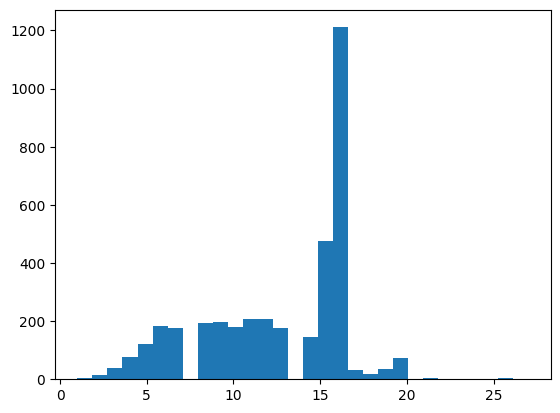

In [101]:
import matplotlib.pyplot as plt

plt.hist(csv_lengths, bins=30)

In [122]:
csv_lengths_counter = Counter(csv_lengths)
csv_lengths_counter

Counter({16: 1211,
         15: 477,
         12: 209,
         11: 209,
         9: 196,
         8: 194,
         6: 182,
         10: 179,
         13: 175,
         7: 175,
         14: 146,
         5: 120,
         4: 76,
         20: 73,
         3: 38,
         19: 35,
         17: 32,
         18: 18,
         2: 14,
         26: 6,
         21: 5,
         1: 3,
         22: 1,
         27: 1,
         25: 1,
         23: 1})

#### csv data extra validation

In [170]:
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
    
    column_headers = df.columns.tolist()
    
    if len(column_headers) != len(chosen_variables):
        print(f'Error in {filename}')

##### Getting variables within x years from bankruptcy

In [3]:
ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')

C:\Users\grzeg\AppData\Local\Temp\ipykernel_52200\1756588558.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')


In [4]:
ecl_dataset_grouped = ecl_dataset.groupby('cik').agg({'bankruptcy_date_1': 'first', 'bankruptcy_date_2': 'first', 'bankruptcy_date_3': 'first','ticker': 'first', 'label': 'last', 'cik-equal-gurufocus-cik': 'last', 'filing_date': 'last'}).reset_index()
ecl_dataset_grouped['is_bankruptcy_date_filled'] = ecl_dataset_grouped['bankruptcy_date_1'].notnull()
ecl_dataset_grouped['is_bankruptcy_date_filled'].value_counts()

is_bankruptcy_date_filled
False    8252
True      891
Name: count, dtype: int64

In [5]:
ecl_dataset_grouped_eligible = ecl_dataset_grouped[ecl_dataset_grouped['cik-equal-gurufocus-cik'] == True]
len(ecl_dataset_grouped_eligible)

5417

In [6]:
def is_date_valid(value):
  try:
    date = pd.to_datetime(value)
    if pd.isnull(date):
      return False
    return True
  except (pd.errors.OutOfBoundsDatetime, ValueError):
    return False

In [17]:
index_to_have_minimal_years_threshold = 5

eligible_companies_with_minimal_years_count = 0
cnt_bankruptcies = 0
cnt_no_bankruptcies = 0
no_date_found = 0

for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
        
        cik = int(filename.split('-')[0])
        label = bool(filename.split('_')[2].split('.')[0])
        
        bankruptcies = ecl_dataset.loc[ecl_dataset['cik'] == cik][['bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3']]
    
        if is_date_valid(bankruptcies['bankruptcy_date_3'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_3'].values[0]
            cnt_bankruptcies += 1
            print(f'bankruptcy_date_3: {filename}')
        elif is_date_valid(bankruptcies['bankruptcy_date_2'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_2'].values[0]
            cnt_bankruptcies += 1
        elif is_date_valid(bankruptcies['bankruptcy_date_1'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_1'].values[0]
            cnt_bankruptcies += 1
        else:
            last_datetime = ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik]['filing_date'].values[0]
            cnt_no_bankruptcies += 1
            
        last_datetime = last_datetime[:7]
        last_datetime = datetime.datetime.strptime(last_datetime, '%Y-%m')
        
        indexes_as_datetime = []
        for index in df.index:
            indexes_as_datetime.append(datetime.datetime.strptime(f'{index}', '%b %Y'))
            
        
        found = False
        for i, date in reversed(list(enumerate(indexes_as_datetime))):
            if date <= last_datetime:
                corresponding_last_date = date
                
                if i >= index_to_have_minimal_years_threshold - 1:
                    # df = df.iloc[i-index_to_have_minimal_years_threshold+1:i + 1]
                    eligible_companies_with_minimal_years_count += 1
                    # df.to_csv(f'{final_financial_data_processed_17_variables_5years_version2_directory}/{filename}', index=True, index_label='Fiscal Period')
                    ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik, 'has_minimal_years'] = True
                    
                    found = True
                break

        if found is False:
            print(f'No date found for {filename}') 
            no_date_found += 1
                
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1001316-US05MF_TGTX_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1009379-US08DK_MDF_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1019272-US0361_ERS_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1029142-US030X_DVAX_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1031308-US28IQ_BSY_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1032462-US09UD_TSY_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1035972-US08FY_MII_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1038133-US03Q6_HSKA_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1039446-US0AMX_JMXIE_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 1042282-US05H8_SSSW_False.csv
Ex: index -2 is out of bounds for axis 0 with size 1, filename: 

In [64]:
print(f'cnt_bankruptcies: {cnt_bankruptcies}, cnt_no_bankruptcies: {cnt_no_bankruptcies}')
print(f'no_date_found: {no_date_found}')

cnt_bankruptcies: 264, cnt_no_bankruptcies: 3513
no_date_found: 358


In [65]:
eligible_companies_with_minimal_years_count

3419

In [61]:
ecl_dataset_grouped_eligible_with_minimal_years = ecl_dataset_grouped_eligible[ecl_dataset_grouped_eligible['has_minimal_years'] == True]

len(ecl_dataset_grouped_eligible_with_minimal_years)

3490

# Dataset for 17 variables exists, with data from 5 years - could be used for training model

In [12]:
# TODO later: save with filename to report - match by bankruptcy or filing date !!!
# TODO: plot labels distribution
ecl_dataset_grouped_eligible_with_minimal_years.to_csv('ecl_dataset_grouped_eligible_with_minimal_years.csv', index=False)

NameError: name 'ecl_dataset_grouped_eligible_with_minimal_years' is not defined

In [3]:
bankrupt_companies_with_17_variables_5_years = pd.DataFrame()

for i, filename in enumerate(os.listdir(final_financial_data_processed_17_variables_5years_directory)):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_5years_directory}/{filename}', index_col='Fiscal Period')
        
        # find all values with M, like 1.2M with 1200000 and replace them with number
        for column in df.columns:
            df[column] = df[column].replace({'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)
        
        filename_without_extension = filename.replace('.csv', '')
        
        label = filename_without_extension.split('_')[-1]

        mapping = {'True': True, 'False': False}
        label = mapping[label]
        
        df.reset_index(inplace=True)
        df.insert(loc=0, column='cik', value=int(filename.split('-')[0]))
        df.insert(loc=1, column='ticker', value=filename.split('_')[1])
        df.insert(loc=2, column='label', value=label)

        bankrupt_companies_with_17_variables_5_years = pd.concat([bankrupt_companies_with_17_variables_5_years, df])
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

bankrupt_companies_with_17_variables_5_years.sort_values(by=['cik', 'Fiscal Period'], inplace=True)
bankrupt_companies_with_17_variables_5_years.to_csv('bankrupt_companies_with_17_variables_5_years_version2.csv', index=False)

In [14]:
bankrupt_companies_with_17_variables_5_years.head()

,cik,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1800,ABT,False,Dec 2016,9094.0,1353.0,1844.0,3197.0,11759.0,20681.0,...,1400.0,25565.0,20853.0,52666.0,26776.0,6660.0,2434.0,31949.0,8733.0,5054.0
1,1800,ABT,False,Dec 2017,12409.0,3021.0,3135.0,6156.0,14981.0,27210.0,...,477.0,23978.0,27390.0,76250.0,20147.0,8912.0,3601.0,45152.0,13417.0,6916.0
2,1800,ABT,False,Dec 2018,12706.0,3278.0,3699.0,6977.0,17872.0,19359.0,...,2368.0,24560.0,30578.0,67173.0,14632.0,9012.0,3796.0,36451.0,14222.0,6750.0
3,1800,ABT,False,Dec 2019,13231.0,3014.0,4747.0,7761.0,18673.0,16661.0,...,3687.0,25847.0,31904.0,67887.0,15667.0,10863.0,4316.0,36586.0,14141.0,7211.0
4,1800,ABT,False,Dec 2020,15003.0,3327.0,5514.0,8841.0,19605.0,18527.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0


In [4]:
# bankrupt_companies_with_17_variables_5_years = pd.read_csv('bankrupt_companies_with_17_variables_5_years.csv')

bankrupt_companies_with_17_variables_5_years_grouped = bankrupt_companies_with_17_variables_5_years.groupby('cik').agg({'label': 'first'}).reset_index()

bankrupt_companies_with_17_variables_5_years_grouped['label'].value_counts(normalize=True)

label
False    0.97924
True     0.02076
Name: proportion, dtype: float64

In [5]:
number_of_companies = len(bankrupt_companies_with_17_variables_5_years_grouped)
number_of_companies

3420

In [30]:
train_ratio = 0.8
validation_ratio = 0.05
test_ratio = 0.15

#### sandbox for reading csv by model & splitting data

In [8]:
bankrupt_companies_with_17_variables_5_years_grouped_false = bankrupt_companies_with_17_variables_5_years_grouped[bankrupt_companies_with_17_variables_5_years_grouped['label'] == False]

false_len = len(bankrupt_companies_with_17_variables_5_years_grouped_false)

bankrupt_companies_with_17_variables_5_years_grouped_true = bankrupt_companies_with_17_variables_5_years_grouped[bankrupt_companies_with_17_variables_5_years_grouped['label'] == True]

true_len = len(bankrupt_companies_with_17_variables_5_years_grouped_true)

train_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[:int(train_ratio * false_len)], bankrupt_companies_with_17_variables_5_years_grouped_true[:int(train_ratio * true_len)]])

validation_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[int(train_ratio * false_len):int((train_ratio + validation_ratio) * false_len)], bankrupt_companies_with_17_variables_5_years_grouped_true[int(train_ratio * true_len):int((train_ratio + validation_ratio) * true_len)]])

test_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[int((train_ratio + validation_ratio) * false_len):], bankrupt_companies_with_17_variables_5_years_grouped_true[int((train_ratio + validation_ratio) * true_len):]])

len(train_set), len(validation_set), len(test_set)

(2735, 171, 514)

In [9]:
train_set.head()

,cik,label
0,1800,False
1,2488,False
2,2491,False
3,2969,False
4,3153,False


In [10]:
train_set['label'].value_counts(normalize=True)

label
False    0.979525
True     0.020475
Name: proportion, dtype: float64

In [11]:
train_set['subset'] = 'train'
validation_set['subset'] = 'val'
test_set['subset'] = 'test'

train_set.drop(columns=['label'], inplace=True)
validation_set.drop(columns=['label'], inplace=True)
test_set.drop(columns=['label'], inplace=True)

subsets = pd.concat([train_set, validation_set, test_set])

subsets = subsets.sample(frac=1).reset_index(drop=True)

final_dataset_with_17_variables_5_years_split_false = subsets.merge(bankrupt_companies_with_17_variables_5_years, on='cik', how='left')

final_dataset_with_17_variables_5_years_split_false.to_csv('bankrupt_companies_with_17_variables_5_years_version2_split.csv', index=False)

final_dataset_with_17_variables_5_years_split_false.head()

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1113232,train,ACLS,False,Dec 2016,167.0,4.0,16.0,20.0,100.0,...,11.0,-332.0,267.0,302.0,241.0,48.0,114.0,101.0,83.0,51.0
1,1113232,train,ACLS,False,Dec 2017,260.0,5.0,49.0,54.0,150.0,...,127.0,-205.0,411.0,488.0,340.0,79.0,121.0,135.0,102.0,75.0
2,1113232,train,ACLS,False,Dec 2018,263.0,6.0,60.0,66.0,180.0,...,46.0,-157.0,443.0,548.0,397.0,85.0,129.0,140.0,120.0,79.0
3,1113232,train,ACLS,False,Dec 2019,199.0,8.0,26.0,34.0,144.0,...,17.0,-140.0,343.0,548.0,376.0,69.0,140.0,129.0,120.0,84.0
4,1113232,train,ACLS,False,Dec 2020,276.0,10.0,61.0,71.0,199.0,...,50.0,-92.0,475.0,625.0,471.0,84.0,161.0,143.0,141.0,87.0


In [12]:
final_dataset_with_17_variables_5_years_split_false['subset'].value_counts(normalize=True)

subset
train    0.799708
test     0.150292
val      0.050000
Name: proportion, dtype: float64

In [97]:
train_set_grouped = final_dataset_with_17_variables_5_years_split_false[final_dataset_with_17_variables_5_years_split_false['subset'] == 'train']
train_set_grouped['label'].value_counts(normalize=True)

label
False    0.979525
True     0.020475
Name: proportion, dtype: float64

In [125]:
df_raw = pd.read_csv('bankrupt_companies_with_17_variables_5_years_split.csv')
df_raw.head()

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1636519,test,MSGS,False,Jun 2017,860.4,107.4,-77.0,30.4,458.0,...,-72.7,-148.4,1318.5,3712.8,1449.7,762.0,0.0,1212.3,514.3,104.8
1,1636519,test,MSGS,False,Jun 2018,419.1,122.5,-17.8,104.7,293.3,...,141.6,-11.1,712.4,3736.2,1415.7,765.5,0.0,1105.5,311.5,101.3
2,1636519,test,MSGS,False,Jun 2019,440.1,119.2,-55.7,63.5,289.3,...,11.4,29.0,729.4,3763.8,1413.3,760.0,0.0,1057.4,347.5,15.5
3,1636519,test,MSGS,False,Jun 2020,360.0,93.4,-93.6,-0.2,243.3,...,-182.4,-43.6,603.3,1233.8,128.3,290.3,0.0,1437.2,337.2,7.5
4,1636519,test,MSGS,False,Jun 2021,281.9,5.6,-78.8,-73.2,133.8,...,-14.0,-78.9,415.7,1309.9,185.2,368.3,0.0,1511.8,212.3,80.6


In [126]:
# df_raw = df_raw.drop(columns=['cik', 'ticker'])

df_train = df_raw[df_raw['subset'] == 'train']
df_validation = df_raw[df_raw['subset'] == 'val']
df_test = df_raw[df_raw['subset'] == 'test']

train_array = df_train.to_numpy()
validation_array = df_validation.to_numpy()
test_array = df_test.to_numpy()

train_array.shape, validation_array.shape, test_array.shape

((13675, 22), (855, 22), (2570, 22))

In [148]:
df_train_y = df_train.groupby('cik').agg({'label': 'first'}).reset_index()
df_train_y = df_train_y['label'].astype(int).to_numpy()
df_train_y.shape

(2735,)

In [151]:
df_train_y.reshape(-1, 5, 1, 1)

array([[[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[1]],

        [[0]],

        [[0]]],


       ...,


       [[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]]]])

In [147]:
train_array = train_array.reshape(-1, 5, df_train.shape[1])
validation_array = validation_array.reshape(-1, 5, df_validation.shape[1])
test_array = test_array.reshape(-1, 5, df_test.shape[1])
train_array.shape, validation_array.shape, test_array.shape

((2735, 5, 22), (171, 5, 22), (514, 5, 22))

In [71]:
batch_size = 32
n_complete_batches = train_array.shape[0] // batch_size
train_samples_aligned_to_batch_size = train_array[:n_complete_batches * batch_size]
batched_array = train_samples_aligned_to_batch_size.reshape(-1, batch_size, 5, 20)
batched_array.shape

(85, 32, 5, 20)

In [143]:
company_observation_period = 5
def get_batched_array(df, batch_size):
    
    df = df.drop(columns=['cik', 'ticker', 'label', 'subset', 'Fiscal Period'])
    
    numpy_array = df.to_numpy()
    variables_count = df.shape[1]
    grouped_by_years_array = numpy_array.reshape(-1, 5, variables_count)
    
    n_complete_batches = grouped_by_years_array.shape[0] // batch_size
    
    array_aligned_to_batch_size = grouped_by_years_array[:n_complete_batches * batch_size]
    batched_array = array_aligned_to_batch_size.reshape(-1, batch_size, company_observation_period, variables_count)
    
    return batched_array

In [144]:
batched_train_array = get_batched_array(df_validation, batch_size)
batched_train_array.shape

(5, 32, 5, 17)

In [145]:
batched_train_array[0][0]

array([[50.2, 36.8, -43.4, -6.7, 107.4, 19.6, '779.8', -37.9, -70.6,
        157.6, 296.9, 92.3, 59.7, 39.2, 202.8, 152.3, 32.8],
       [62.8, 33.3, -57.5, -24.2, 123.9, 36.9, '779.8', -59.6, -130.2,
        186.7, 299.2, 101.9, 35.6, 52.6, 40.7, 171.8, 33.9],
       [71.8, 24.9, -38.1, -13.1, 144.2, 36.9, '816.0', -39.2, -169.4,
        216.0, 374.5, 155.2, 47.8, 62.0, 87.8, 180.5, 38.8],
       [82.2, 29.2, -37.2, -7.9, 154.5, 36.9, '847.2', -41.7, -211.1,
        236.6, 383.5, 160.0, 44.1, 61.9, 122.0, 189.2, 46.4],
       [88.6, 26.8, -31.7, -4.9, 169.4, 39.2, '780.7', -37.1, -249.2,
        258.0, 373.1, 153.7, 54.1, 71.4, 130.7, 202.8, 50.5]],
      dtype=object)

In [32]:
df = df_raw.drop(columns=['cik', 'ticker'])
df = df.to_numpy()

result_df = df.reshape(-1, 5, df.shape[1]) 

result_df.shape

(3420, 5, 20)

In [10]:
result_df[0]

array([[1045810, 'train', 'NVDA', False, 'Jan 2017', 2847.0, 187.0,
        1963.0, 2150.0, 4063.0, 1983.0, '63870.0', 1666.0, 6108.0,
        6910.0, 9841.0, 8536.0, 1819.0, 794.0, 4079.0, 2126.0, 826.0],
       [1045810, 'train', 'NVDA', False, 'Jan 2018', 3892.0, 199.0,
        3257.0, 3456.0, 5822.0, 1985.0, '148955.0', 3047.0, 8787.0,
        9714.0, 11241.0, 9255.0, 1153.0, 796.0, 3770.0, 2612.0, 1265.0],
       [1045810, 'train', 'NVDA', False, 'Jan 2019', 4545.0, 262.0,
        3954.0, 4216.0, 7171.0, 1988.0, '87113.0', 4141.0, 12565.0,
        11716.0, 13292.0, 10557.0, 1329.0, 1575.0, 3950.0, 3367.0,
        1424.0],
       [1045810, 'train', 'NVDA', False, 'Jan 2020', 4150.0, 381.0,
        3022.0, 3403.0, 6768.0, 1991.0, '144810.0', 2796.0, 14971.0,
        10918.0, 17315.0, 13690.0, 1784.0, 979.0, 5111.0, 3922.0, 1657.0],
       [1045810, 'train', 'NVDA', False, 'Jan 2021', 6279.0, 1098.0,
        4593.0, 5691.0, 10396.0, 5964.0, '322146.0', 4332.0, 18908.0,
        16675.

In [34]:
106*32

3392

In [6]:
bankrupt_companies_with_17_variables_5_years_version2_split = pd.read_csv('./bankrupt_companies_with_17_variables_5_years_version2_split.csv')
bankrupt_companies_with_17_variables_5_years_version2_split.head()

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1113232,train,ACLS,False,Dec 2016,167.0,4.0,16.0,20.0,100.0,...,11.0,-332.0,267.0,302.0,241.0,48.0,114.0,101.0,83.0,51.0
1,1113232,train,ACLS,False,Dec 2017,260.0,5.0,49.0,54.0,150.0,...,127.0,-205.0,411.0,488.0,340.0,79.0,121.0,135.0,102.0,75.0
2,1113232,train,ACLS,False,Dec 2018,263.0,6.0,60.0,66.0,180.0,...,46.0,-157.0,443.0,548.0,397.0,85.0,129.0,140.0,120.0,79.0
3,1113232,train,ACLS,False,Dec 2019,199.0,8.0,26.0,34.0,144.0,...,17.0,-140.0,343.0,548.0,376.0,69.0,140.0,129.0,120.0,84.0
4,1113232,train,ACLS,False,Dec 2020,276.0,10.0,61.0,71.0,199.0,...,50.0,-92.0,475.0,625.0,471.0,84.0,161.0,143.0,141.0,87.0


In [7]:
bankrupt_companies_with_17_variables_5_years_version2_split_grouped = bankrupt_companies_with_17_variables_5_years_version2_split.groupby('cik').agg({'label': 'first'}).reset_index()
len(bankrupt_companies_with_17_variables_5_years_version2_split_grouped)

3420

In [11]:
bankrupt_companies_with_17_variables_5_years_version2_split_grouped['label'].value_counts()

label
False    3349
True       71
Name: count, dtype: int64

In [32]:
bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false = bankrupt_companies_with_17_variables_5_years_version2_split_grouped[bankrupt_companies_with_17_variables_5_years_version2_split_grouped['label'] == False][:71]
false_len = len(bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false)

true_len = len(bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false)

train_set = bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false[:int(train_ratio * false_len)]

validation_set = bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false[int(train_ratio * false_len):int((train_ratio + validation_ratio) * false_len)]

test_set = bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false[int((train_ratio + validation_ratio) * false_len):]

len(train_set), len(validation_set), len(test_set)

(56, 4, 11)

In [36]:
train_set['subset'] = 'train'
validation_set['subset'] = 'val'
test_set['subset'] = 'test'

subsets = pd.concat([train_set, validation_set, test_set])

subsets = subsets.sample(frac=1).reset_index(drop=True)

final_dataset_with_17_variables_5_years_split_false = subsets.merge(bankrupt_companies_with_17_variables_5_years_version2_split_grouped_false, on='cik', how='left')

final_dataset_with_17_variables_5_years_split_false.head()

C:\Users\grzeg\AppData\Local\Temp\ipykernel_41740\1858762378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['subset'] = 'train'
C:\Users\grzeg\AppData\Local\Temp\ipykernel_41740\1858762378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['subset'] = 'val'
C:\Users\grzeg\AppData\Local\Temp\ipykernel_41740\1858762378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,cik,subset,label
0,12927,train,False
1,4285,train,False
2,10795,train,False
3,14707,val,False
4,6281,train,False


In [46]:
reduced_balanced_set_false = bankrupt_companies_with_17_variables_5_years_version2_split[bankrupt_companies_with_17_variables_5_years_version2_split['cik'].isin(final_dataset_with_17_variables_5_years_split_false['cik'])]

print(len(reduced_balanced_set_false))
reduced_balanced_set_false.head()

355


,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
30,6571,train,AGL,False,Jan 2002,267.0,14.0,14.0,28.0,49.0,...,6.0,145.0,316.0,289.0,93.0,56.0,0.0,138.0,38.0,44.0
31,6571,train,AGL,False,Jan 2003,267.0,14.0,14.0,28.0,49.0,...,6.0,145.0,316.0,289.0,93.0,56.0,0.0,138.0,38.0,44.0
32,6571,train,AGL,False,Jan 2004,267.0,14.0,14.0,28.0,49.0,...,6.0,145.0,316.0,289.0,93.0,56.0,0.0,138.0,38.0,44.0
33,6571,train,AGL,False,Jan 2005,267.0,14.0,14.0,28.0,49.0,...,6.0,145.0,316.0,289.0,93.0,56.0,0.0,138.0,38.0,44.0
34,6571,train,AGL,False,Jan 2006,364.0,20.0,8.0,27.0,54.0,...,0.0,141.0,418.0,331.0,110.0,81.0,0.0,182.0,48.0,58.0


In [47]:
reduced_balanced_set_false.drop(columns=['subset'], inplace=True)

C:\Users\grzeg\AppData\Local\Temp\ipykernel_41740\431981850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_balanced_set_false.drop(columns=['subset'], inplace=True)


In [48]:
final_dataset_with_17_variables_5_years_split_false = subsets.merge(reduced_balanced_set_false, on='cik', how='left')
final_dataset_with_17_variables_5_years_split_false.head()
# final false

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,12927,train,BA,False,Dec 2016,79026.0,1889.0,6089.0,7978.0,14470.0,...,5034.0,40714.0,93496.0,89997.0,62488.0,50134.0,43199.0,89120.0,8239.0,9260.0
1,12927,train,BA,False,Dec 2017,76612.0,2047.0,10467.0,12514.0,17393.0,...,8458.0,49618.0,94005.0,112362.0,85194.0,74648.0,61388.0,110649.0,7274.0,11397.0
2,12927,train,BA,False,Dec 2018,81490.0,2114.0,12079.0,14193.0,19637.0,...,10460.0,55941.0,101127.0,117359.0,87830.0,81590.0,62567.0,116949.0,7836.0,14364.0
3,12927,train,BA,False,Dec 2019,72093.0,2271.0,-1537.0,734.0,4466.0,...,-636.0,50644.0,76559.0,133625.0,102229.0,97312.0,76622.0,141925.0,7128.0,12471.0
4,12927,train,BA,False,Dec 2020,63843.0,2246.0,-12320.0,-10074.0,-5685.0,...,-11941.0,38610.0,58158.0,152136.0,121642.0,87280.0,81715.0,170211.0,7293.0,10051.0


In [43]:
# final grouped
bankrupt_companies_with_17_variables_5_years_version2_split_grouped_true = bankrupt_companies_with_17_variables_5_years_version2_split_grouped[bankrupt_companies_with_17_variables_5_years_version2_split_grouped['label'] == True]

reduced_balanced_set_true = bankrupt_companies_with_17_variables_5_years_version2_split[bankrupt_companies_with_17_variables_5_years_version2_split['cik'].isin(bankrupt_companies_with_17_variables_5_years_version2_split_grouped_true['cik'])]

reduced_balanced_set_true.head()

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
50,790414,train,GOTTQ,True,Jan 2004,432.0,13.0,18.0,31.0,236.0,...,5.0,40.0,669.0,316.0,175.0,80.0,153.0,203.0,220.0,7.0
51,790414,train,GOTTQ,True,Jan 2005,432.0,13.0,18.0,31.0,236.0,...,5.0,40.0,669.0,316.0,175.0,80.0,153.0,203.0,220.0,7.0
52,790414,train,GOTTQ,True,Jan 2006,437.0,12.0,17.0,31.0,239.0,...,5.0,45.0,677.0,335.0,188.0,91.0,160.0,215.0,223.0,7.0
53,790414,train,GOTTQ,True,Jan 2007,447.0,14.0,15.0,30.0,241.0,...,3.0,48.0,687.0,350.0,202.0,85.0,169.0,225.0,227.0,8.0
54,790414,train,GOTTQ,True,Jan 2008,421.0,19.0,-10.0,9.0,216.0,...,-12.0,35.0,636.0,332.0,179.0,74.0,149.0,220.0,226.0,7.0


In [52]:
final_reduced_balanced_set = pd.concat([final_dataset_with_17_variables_5_years_split_false, reduced_balanced_set_true])

final_reduced_balanced_set['label'].value_counts(normalize=True)


label
False    0.5
True     0.5
Name: proportion, dtype: float64

In [54]:
final_reduced_balanced_set[final_reduced_balanced_set['label'] == True]['subset'].value_counts(normalize=True)

subset
train    0.788732
test     0.154930
val      0.056338
Name: proportion, dtype: float64

In [55]:
final_reduced_balanced_set.to_csv('reduced_balanced_set.csv', index=False)

In [57]:
# we need to shuffle the data
final_reduced_balanced_set_grouped = final_reduced_balanced_set.groupby('cik').agg({'label': 'first', 'subset': 'first'}).reset_index()

# shuffle the data
final_reduced_balanced_set_grouped = final_reduced_balanced_set_grouped.sample(frac=1).reset_index(drop=True)

final_reduced_balanced_set_shuffled = final_reduced_balanced_set_grouped.merge(final_reduced_balanced_set, on='cik', how='left')

final_reduced_balanced_set_shuffled.drop(columns=['label_y', 'subset_y'], inplace=True)

final_reduced_balanced_set_shuffled.rename(columns={'label_x': 'label', 'subset_x': 'subset'}, inplace=True)

final_reduced_balanced_set_shuffled.to_csv('reduced_balanced_set_shuffled.csv', index=False)


#### Processing II - creating set of files with 100 variables

In [ ]:
max_lacking_variables_threshold_most_common_variables = 12